In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" #"1"
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

device = "cuda"

In [2]:
import transformer_lens as tl
from transformer_lens.FactoredMatrix import FactoredMatrix
import torch 
from cupbearer import tasks
import circuitsvis as cv

torch.set_grad_enabled(False)

In [3]:
cv.examples.hello("Oliver")

# Interpreting If Else In a 1-Layer Transformer

Background: https://transformer-circuits.pub/2021/framework/index.html#splitting-attention-head-terms-into-circuits

and more recently https://transformer-circuits.pub/2024/july-update/index.html#pivot-tables
    - note: need to take care to handle layer norm properly




Research Questions/Steps
1. Is the ["else", "if"] entry of the W_{OV} matrix high relative to other entries in [:, "if"]
2. What are other high entries in ["else", :]
3. Is the [")", "if"] entry of the W_{QK} matrix high relative to other entries in [:, "if"],
4. What are the other high entries in [:, "if"]
5. How do we handle positional entries...]



...
6. Can we reconstruct model beahvior using a subcircuit of the QK, OV circuits
7. How distinst are the circuits?


8. How (if at all) can we compute attributions on the QK, OV circuits 
9. Can the attributions distinguish training and test cases?

## Understand the architecure of the 1-Layer Transformer

In [4]:
model = tl.HookedTransformer.from_pretrained(
    "attn-only-1l",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    fold_value_biases=False,
).to(device)

# this does have pre-attention layer norm and pre-unembedding layer norm (though no pre-emebdding layer norm - in this case that would be redundant anyway)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cuda


In [5]:
# I want to think a little more 
# so at the destination token, we could compute 

# seems like the genearal procedure is 
    # look at the OV for [answer, tokens] for all tokens. Filter for positive values (maybe normalization screws this up)
    # then for each relevant token, track the QV for the positional embedding, and token
        # maybe do some kind of dimensionality reduction? 
        # we want to be doing somethine like capturing the "reason" for attenting to the tokens 
            # on if else, this is probably ")" or distane to else 1-3

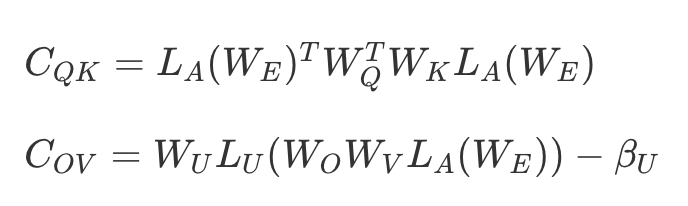

In [6]:
def print_token_order(topk_inds, token):
    for ind in torch.nonzero(topk_inds.indices == token):
        print(ind[0].item(), ind[1].item(), (1 - ind[1] / topk_inds.indices.shape[-1]).item())

In [7]:
task = tasks.tiny_natural_mechanisms("ifelse", device)
model: tl.HookedTransformer = task.model

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cuda


In [8]:
if_token = task.model.tokenizer.encode(" if")[0]
if_token_alt = task.model.tokenizer.encode("if")[0]
elif_token = task.model.tokenizer.encode(" elif")[0]
else_token = task.model.tokenizer.encode(" else")[0]

## OV Matrix

In [9]:
C_OV = FactoredMatrix( # note transformer lens uses right multiplying for weights (i.e. X @ W)
    model.ln_final((model.blocks[0].ln1(model.W_E) @ model.OV.AB)),#N_v, d_model
    model.unembed.W_U, # d_model, N_v
)
C_OV = C_OV.T # tranpose so indexing is [out, value]

### TopK Values (If) that Promote Output (Else)

In [10]:
# the top tokens that promote else
top_k_else = (C_OV[0, :, else_token, :].AB.squeeze(-2) - model.unembed.b_U[else_token]).topk(C_OV.shape[-1])

In [11]:
print_token_order(top_k_else, if_token_alt)

0 10512 0.782188892364502
1 132 0.9972649216651917
2 44806 0.07160913944244385
3 2647 0.945153534412384
4 7200 0.8508142828941345
5 9744 0.7981020212173462
6 3873 0.9197505116462708
7 36147 0.25102561712265015


In [12]:
print_token_order(top_k_else, if_token)

0 28439 0.41073721647262573
1 0 1.0
2 42001 0.12972939014434814
3 63 0.9986945986747742
4 4 0.9999170899391174
5 109 0.9977415204048157
6 5251 0.8911980390548706
7 44756 0.07264512777328491


In [13]:
print_token_order(top_k_else, elif_token)

0 30611 0.3657328486442566
1 1 0.9999792575836182
2 44659 0.07465499639511108
3 357 0.9926028847694397
4 237 0.9950892925262451
5 2845 0.9410509467124939
6 10447 0.7835357189178467
7 48108 0.0031908750534057617


In [20]:
# top tokens that promote Obama 
obama_tokens = task.model.tokenizer.encode(" Obama")
assert len(obama_tokens) == 1
obama_token = obama_tokens[0]
barack_token = task.model.tokenizer.encode(" Barack")
assert len(barack_token) == 1
barack_token = barack_token[0]
top_k_obama = (C_OV[0, :, obama_token, :].AB.squeeze(dim=-2) - model.unembed.b_U[obama_token]).topk(C_OV.shape[-1])
print_token_order(top_k_obama, barack_token)


0 8587 0.822075366973877
1 2935 0.9391860961914062
2 1108 0.9770419597625732
3 0 1.0
4 6 0.9998756647109985
5 10064 0.791471540927887
6 1106 0.9770834445953369
7 984 0.9796112775802612


### TopK Outputs (Else) Prompted by Values (If)

In [21]:
# the top tokens if promotes 
top_k_if = (C_OV[0, :, :, if_token].AB.squeeze(-1) - model.unembed.b_U).topk(C_OV.shape[-1])

In [22]:
print_token_order(top_k_if, else_token)

0 1819 0.9623098969459534
1 0 1.0
2 3487 0.9277485609054565
3 33 0.9993162155151367
4 1 0.9999792575836182
5 9 0.9998134970664978
6 864 0.9820977449417114
7 9088 0.8116945028305054


In [23]:
top_k_alt_if = (C_OV[0, :, :, if_token_alt].AB.squeeze(-1) - model.unembed.b_U).topk(C_OV.shape[-1])

In [24]:
print_token_order(top_k_alt_if, else_token)

0 584 0.9878993630409241
1 4 0.9999170899391174
2 4832 0.8998798131942749
3 151 0.9968712329864502
4 257 0.9946749210357666
5 277 0.9942604899406433
6 203 0.9957938194274902
7 2783 0.9423356056213379


### Summary 

" if" very strongly promotes else compared to other outputs across almost every attention head, but " if" as a value is a middlinng promoter of else compared to other values ("if" ranks somewhat higher)

# QK Matrix

![Screenshot 2024-07-31 at 2.33.10 PM.png](<attachment:Screenshot 2024-07-31 at 2.33.10 PM.png>)
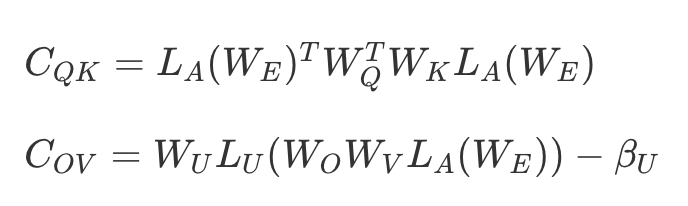

In [25]:
C_QK = FactoredMatrix(
    model.blocks[0].ln1(model.W_E) @ model.W_K,
    model.W_Q.transpose(2,3) @ model.blocks[0].ln1(model.W_E).T
)
C_QK = C_QK.T

In [26]:
close_paran_token = task.model.tokenizer.encode(" )")
assert len(close_paran_token) == 1
close_paran_token = close_paran_token[0]
close_paran_alt_token = task.model.tokenizer.encode(")")
assert len(close_paran_alt_token) == 1
close_paran_alt_token = close_paran_alt_token[0]

### TopK Keys (" if") that a Given Query (")") attends to 

In [27]:
top_k_close_paran_keys = (C_QK[0, :, close_paran_token, :].AB.squeeze(-2)).topk(C_QK.shape[-1])

In [28]:
print_token_order(top_k_close_paran_keys, if_token)

0 6 0.9998756647109985
1 748 0.9845012426376343
2 13455 0.7212092280387878
3 93 0.9980730414390564
4 3378 0.9300070405006409
5 1236 0.9743897914886475
6 20501 0.5752144455909729
7 20360 0.5781359672546387


In [29]:
print_token_order(top_k_close_paran_keys, if_token_alt)

0 14244 0.7048609256744385
1 1894 0.9607558846473694
2 841 0.9825742840766907
3 2658 0.9449256062507629
4 23053 0.5223363637924194
5 569 0.9882102012634277
6 44984 0.06792092323303223
7 35446 0.26555055379867554


### TopK Queries (")") that a Given Key (" if") is attended to by

In [30]:
top_k_if_queries = (C_QK[0, :, :, if_token].AB.squeeze(-1)).topk(C_QK.shape[-1])

In [31]:
print_token_order(top_k_if_queries, close_paran_token)

0 28 0.9994198083877563
1 1407 0.9708466529846191
2 15227 0.6844929456710815
3 45 0.9990676045417786
4 2446 0.9493182897567749
5 248 0.994861364364624
6 19148 0.6032489538192749
7 26671 0.44737058877944946


## Positional Encodings

In [32]:
model.pos_embed.W_pos.shape

torch.Size([1024, 512])

#  If Else Task

## Trusted

In [171]:
x_trusted = task.trusted_data[7]
out_trusted, trusted_cache = model.run_with_cache(x_trusted[0], remove_batch_dim=True)
task.model.tokenizer.decode(x_trusted[0])

" if method is None:\n            method = 'POST' if data is not None"

In [172]:
out_trusted[0, -1, else_token]

tensor(16.1997, device='cuda:0')

In [173]:
out_else_prob = out_trusted[0, -1].softmax(dim=-1)[else_token].item()
out_else_prob

0.4533679783344269

In [174]:
out_trusted_topk = out_trusted[:, -1].topk(out_trusted.size(-1))
print_token_order(out_trusted_topk, else_token)

0 0 1.0


In [175]:
# lets see if we can understand 95% of the positive contribution to the else token logits 

In [176]:
# first, we compute the attention pattern to see how we weight the values from the context 
attention_pattern = trusted_cache["pattern", 0, "attn"]
x_trusted_str_tokens = model.to_str_tokens(x_trusted[0])

In [177]:
print("Head Attention Patterns:")
cv.attention.attention_patterns(tokens=x_trusted_str_tokens, attention=attention_pattern)


Head Attention Patterns:


In [184]:
# looks like 4, 5, and 7 are attending to if the most
for ind in torch.nonzero(x_trusted[0] == if_token):
    print(attention_pattern[:, -1, ind.item()])

tensor([0.1645, 0.6340, 0.3265, 0.1882, 0.0135, 0.0092, 0.2931, 0.0370],
       device='cuda:0')
tensor([0.2594, 0.0317, 0.0618, 0.1288, 0.1073, 0.4954, 0.0411, 0.1197],
       device='cuda:0')


In [185]:
def get_C_OV_from_input(tokens, model: tl.HookedTransformer) -> FactoredMatrix:
    emb = model.input_to_embed(tokens)[0].squeeze(0)
    c_OV = FactoredMatrix(
        model.ln_final((model.blocks[0].ln1(emb) @ model.OV.AB)),
        model.unembed.W_U,
    )
    return c_OV.T

In [186]:
# then, we compute output else token logits from each input token in the context, using the positional embeddings
# hmm, is this actually the correct way to go about this?... maybe just ignore postion for now, see what happens?
C_OV_trusted = get_C_OV_from_input(x_trusted[0], model)
C_O_else_V_trusted = C_OV_trusted[:, :, else_token, :].AB.squeeze()

In [187]:
for i, token_str in enumerate(x_trusted_str_tokens):
    print(i, token_str, C_O_else_V_trusted[:, i].tolist())

0  if [3.0729141235351562, 13.140405654907227, -1.1051559448242188, -2.0344667434692383, 2.8569107055664062, 6.15522575378418, 4.46773099899292, 4.899585723876953]
1  method [2.557582378387451, -1.3182499408721924, 2.731884002685547, 6.623106479644775, 3.7691280841827393, 2.4949233531951904, -0.37118029594421387, 2.9317092895507812]
2  is [0.3913043737411499, -0.02278447151184082, 3.780076026916504, 1.0163321495056152, 3.909078598022461, 1.5487995147705078, 9.978903770446777, 1.2917176485061646]
3  None [1.6345374584197998, 0.6655652523040771, 4.0886383056640625, -0.5585246682167053, 11.883514404296875, 0.016852200031280518, 1.1915329694747925, 4.153181552886963]
4 : [2.521273136138916, 3.7874977588653564, -0.9438263177871704, 3.448094606399536, -7.511634826660156, -1.1024961471557617, 1.7645456790924072, 4.578381061553955]
5 
            [3.1152830123901367, -7.153103828430176, 6.029910087585449, 8.85386848449707, -0.8748493194580078, -7.142395973205566, -2.7717320919036865, 8.4567584

In [45]:
# apply attention pattern
weighted_C_O_else_V_trusted = (attention_pattern[:, -1] * C_O_else_V_trusted)
# finally, we sum up the contributions, verify it is close to the actual output else token logits, then sum up the positive contributions
# and divide each contribution by the sum 
weighted_C_O_else_V_trusted.sum(), out_trusted[0, -1, else_token], (weighted_C_O_else_V_trusted.sum() / out_trusted[0, -1, else_token])
# NOTE: very far off, need to review

(tensor(25.0659, device='cuda:0'),
 tensor(7.2137, device='cuda:0'),
 tensor(3.4748, device='cuda:0'))

In [46]:
# see if logits are roughly proportional
C_OV_trusted = FactoredMatrix(
    model.ln_final((model.blocks[0].ln1(trusted_emb) @ model.OV.AB)), 
    model.unembed.W_U
)
C_OV_trusted = C_OV_trusted.T
C_OV_trusted.shape

torch.Size([1, 8, 48262, 16])

In [47]:
C_O_elif_V_trusted = C_OV_trusted[:, :, elif_token, :].AB.squeeze(-2)
weighed_C_O_elif_V_trusted = (attention_pattern[:, -1] * C_O_elif_V_trusted)
weighed_C_O_elif_V_trusted.sum(), out_trusted[0, -1, elif_token], weighed_C_O_elif_V_trusted.sum() / out_trusted[0, -1, elif_token]
# maybe proportional or something like that? I'm going to try using the OV without the positional embeddings

(tensor(-3.4579, device='cuda:0'),
 tensor(-0.6739, device='cuda:0'),
 tensor(5.1316, device='cuda:0'))

In [48]:
(attention_pattern[:, -1] * torch.gather(C_OV[0, :, else_token, :].AB, -1, x_trusted[0].to(device).expand((C_OV.shape[1], 1, x_trusted[0].size(0)))).squeeze(-2)).sum() 
# huh basically no impact of positional embeddings (at least on else)
# For now I'll just try to account for 95% of the sum of the positive contributions, try to understand the difference between this and the logits later

tensor(25.4148, device='cuda:0')

In [ ]:
# ok - some ideas for detectors
# 1. track scores for each token (OV[out, token]/OV[out, :].sum() * attention weight), and use this as feature (mahablanois, could try with isotropic gaussian)
    # varients - track per attention head or aggregate across heads
    # note this makes no reference to the input token 
    # potential worries: similarity between trusted and anomalous - could have trusted which attends very strongly to if a similar way, but maybe 
# 2. track scores for each token (OV[out, token]/OV[out, :].sum() * attention weight), and use this as feature (mahablanois, could try with isotropic gaussian)
    

In [ ]:
# (old)
# we want to disengtale the token embedding effect from the positional embedding effect by decomposing the OV
# to do so, our approach will be to run a forward pass, fix the layer norm, then pass

## Anomalous Data

In [164]:
x_anom = task.test_data.anomalous_data[32]
out_anom, anom_cache = model.run_with_cache(x_anom[0], remove_batch_dim=True)
task.model.tokenizer.decode(x_anom[0])

'splitlines(True):\n                yield (prefix + line if predicate(line)'

In [165]:
out_anom[0, -1, else_token]

tensor(12.6663, device='cuda:0')

In [166]:
out_anom_else_prob = out_anom[0, -1].softmax(dim=-1)[else_token].item()
out_anom_else_prob

0.11619271337985992

In [167]:
out_anom_topk = out_anom[:, -1].topk(out_anom.size(-1))
print_token_order(out_anom_topk, else_token)

0 1 0.9999792575836182


In [168]:
# first, we compute the attention pattern to see how we weight the values from the context 
attention_pattern_anom = anom_cache["pattern", 0, "attn"]
x_anom_str_tokens = model.to_str_tokens(x_anom[0])

In [169]:
print("Head Attention Patterns:")
cv.attention.attention_patterns(tokens=x_anom_str_tokens, attention=attention_pattern_anom)


Head Attention Patterns:


In [170]:
# interesting - not as much attention as I would have expected on if
# tends to be head 3 that attends to if
attention_pattern_anom[:, -1, torch.nonzero(x_anom[0] == if_token).item()]

tensor([0.2941, 0.0996, 0.0068, 0.1014, 0.6056, 0.5923, 0.0269, 0.3007],
       device='cuda:0')

In [117]:
# then, we compute output else token logits from each input token in the context, using the positional embeddings
# hmm, is this actually the correct way to go about this?... maybe just ignore postion for now, see what happens?
C_OV_anom = get_C_OV_from_input(x_anom[0], model)
C_O_else_V_anom = C_OV_anom[:, :, else_token, :].AB.squeeze()

In [118]:
for i, token_str in enumerate(x_anom_str_tokens):
    print(i, token_str, C_O_else_V_anom[:, i].tolist())
# fairly similar profile on if regardless of token position (could check this more exaustivly)

0 ) [3.0508408546447754, 6.137648582458496, 1.363257884979248, -4.185632705688477, 1.8399096727371216, 5.209498405456543, 1.9342440366744995, 5.473867893218994]
1 
    [3.2193517684936523, -1.6792175769805908, 3.551664113998413, 4.048112869262695, -0.45860397815704346, -2.91904878616333, -2.1871209144592285, 2.407130241394043]
2  signature [2.218006134033203, 3.6586012840270996, 3.5314583778381348, 3.5964009761810303, 2.003998279571533, 2.5969643592834473, 1.4005721807479858, -1.016397476196289]
3  = [1.9061551094055176, 0.8560788631439209, 1.5692740678787231, 0.8204017281532288, 7.005457878112793, 2.365267038345337, 8.950993537902832, 3.30773663520813]
4  ' [1.721803069114685, 1.4453824758529663, 3.3334622383117676, 2.6290063858032227, -0.6597057580947876, 1.1874501705169678, 5.7169108390808105, 3.0893847942352295]
5 D [-0.09272921085357666, 1.7332260608673096, 3.83213472366333, 0.7376636266708374, 3.17535138130188, 0.244002103805542, 2.9904017448425293, 4.375466346740723]
6 -> [5.144

In [119]:
# apply attention pattern
weighted_C_O_else_V_anom = (attention_pattern_anom[:, -1] * C_O_else_V_anom)
# finally, we sum up the contributions, verify it is close to the actual output else token logits, then sum up the positive contributions
# and divide each contribution by the sum 
weighted_C_O_else_V_anom.sum(), out_anom[0, -1, else_token], (weighted_C_O_else_V_anom.sum() / out_anom[0, -1, else_token])
# NOTE: very far off, need to review

(tensor(34.2381, device='cuda:0'),
 tensor(12.6904, device='cuda:0'),
 tensor(2.6980, device='cuda:0'))

In [ ]:
# ok how to implement the algorithm...

In [ ]:
# ok lots of things to think about here:
    # 1. token output does seem somewhat sensitive to token positon (see e.g. if at beginning vs end), so either need to capture all tokens at all postions, or 
    #   use something like an SAE on embeddings approach
    # 2. just from looking at random examples, seems like there's some seperation (e.g. anomalous examples using head 3 more often) but nothing super clear

# ok lets consider the case where we're looking at all tokens from all positions
    # two algorithms
        #1. sort head, dest token, src token by OV else value on trusted, take top k that can achieve 95% of total value. Flag as anomalous examples where these pairings cannot account for 95% 
            # problem: could have pairs which barely make the cut on trusted, but are really important on anomalous
        #2. track mean and variance of each pair, flag as anomalous if the pair is 2 std devs to the right of the mean 
            # problem: correlation matters, if e.g. all pairs are slightly larger this leads to large differences, could track covariances but higher order statistics still matter